# CNN for rock-paper-scissors with Keras/TensorFlow

Date: January 4, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [48]:
DATA_FOLDER = '../thermography/data/'

FILES = 24
TRAINING_FILES = 16
TEST_FILES = FILES - TRAINING_FILES

In [49]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp

In [50]:
# Normalization
def scale(data):
    min_ = np.min(data)
    max_ = np.max(data)
    mean = (max_ + min_) / 2.0
    range_ = (max_ - min_) / 2.0
    data = (data - mean)/range_
    return data

In [51]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            #training_set.append((pp.scale(data), class_number))
            training_set.append((scale(data), class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            #test_set.append((pp.scale(data), class_number))
            test_set.append((scale(data), class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


array([[-0.96363636, -0.67272727, -0.85454545, -0.63636364, -0.96363636,
        -0.63636364, -0.85454545, -1.        ],
       [-0.78181818, -0.49090909, -0.54545455,  0.12727273, -0.67272727,
         0.09090909, -0.12727273, -0.85454545],
       [-0.54545455, -0.27272727,  0.        ,  0.27272727, -0.09090909,
         0.23636364,  0.23636364, -0.67272727],
       [-0.49090909, -0.54545455,  0.41818182,  0.6       ,  0.63636364,
         0.49090909,  0.30909091, -0.63636364],
       [-0.63636364, -0.6       ,  0.36363636,  0.85454545,  0.81818182,
         0.90909091,  0.18181818, -0.63636364],
       [-0.63636364, -0.63636364,  0.45454545,  0.90909091,  0.90909091,
         0.90909091,  0.18181818,  0.18181818],
       [-0.67272727, -0.45454545,  0.49090909,  1.        ,  0.90909091,
         0.90909091,  0.81818182,  0.23636364],
       [-0.6       , -0.30909091,  0.45454545,  0.85454545,  0.90909091,
         0.72727273,  0.23636364,  0.23636364]])

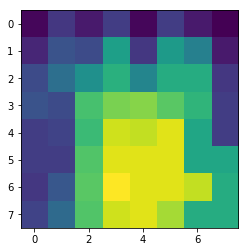

In [52]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data).reshape((TRAINING_FILES*len(class_labels), 8, 8, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data).reshape((TEST_FILES*len(class_labels), 8, 8, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12,:,:,0])
train_data[12,:,:,0]

### CNN model

In [53]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 1)))

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 8, 8, 8)           80        
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 16)          1168      
_________________________________________________________________
flatten_13 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 3075      
Total params: 4,323
Trainable params: 4,323
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

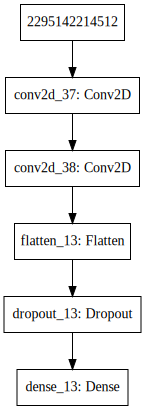

In [55]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [56]:
EPOCHS = 50
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 48 samples, validate on 24 samples
Epoch 1/50
48/48 [==============================] - 1s 16ms/step - loss: 1.1101 - acc: 0.2917 - val_loss: 1.0460 - val_acc: 0.6667
Epoch 2/50
48/48 [==============================] - 0s 263us/step - loss: 1.0674 - acc: 0.4375 - val_loss: 1.0074 - val_acc: 0.7917
Epoch 3/50
48/48 [==============================] - 0s 260us/step - loss: 1.0129 - acc: 0.5417 - val_loss: 0.9747 - val_acc: 0.7500
Epoch 4/50
48/48 [==============================] - 0s 237us/step - loss: 0.9723 - acc: 0.5417 - val_loss: 0.9436 - val_acc: 0.7917
Epoch 5/50
48/48 [==============================] - 0s 258us/step - loss: 0.9302 - acc: 0.6667 - val_loss: 0.9079 - val_acc: 0.7083
Epoch 6/50
48/48 [==============================] - 0s 250us/step - loss: 0.8925 - acc: 0.7292 - val_loss: 0.8702 - val_acc: 0.7500
Epoch 7/50
48/48 [==============================] - 0s 363us/step - loss: 0.8722 - acc: 0.5833 - val_loss: 0.8367 - val_acc: 0.7500
Epoch 8/50
48/48 [===============

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


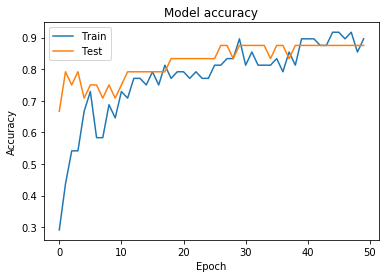

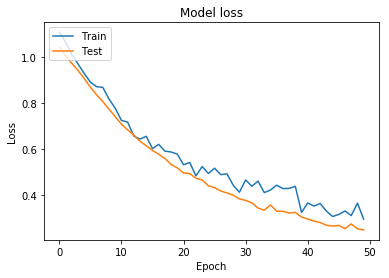

In [57]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [58]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_rock_paper_scissors{}.h5'.format(dt)
model.save(filename)

## Load the model

In [59]:
del model
model = models.load_model(filename)

## Confirmation

In [60]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(48, 8, 8, 1)

In [61]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [62]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [63]:
class_labels

['paper', 'rock', 'scissors']

In [64]:
(activations[-1][:10]*100).astype(int)

array([[31, 68,  0],
       [19, 77,  2],
       [14, 77,  7],
       [97,  2,  0],
       [93,  6,  0],
       [24, 75,  0],
       [ 0,  4, 95],
       [94,  4,  1],
       [ 0,  1, 98],
       [84, 15,  0]])

In [65]:
test_labels[:10].astype(int)

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [66]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(activations[layer][sample, :, :, i])
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'paper'

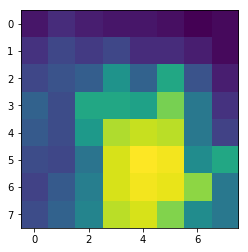

In [67]:
image_number = 10

plt.imshow(test_data[image_number,:,:,0])
class_labels[np.argmax(test_labels[image_number])]

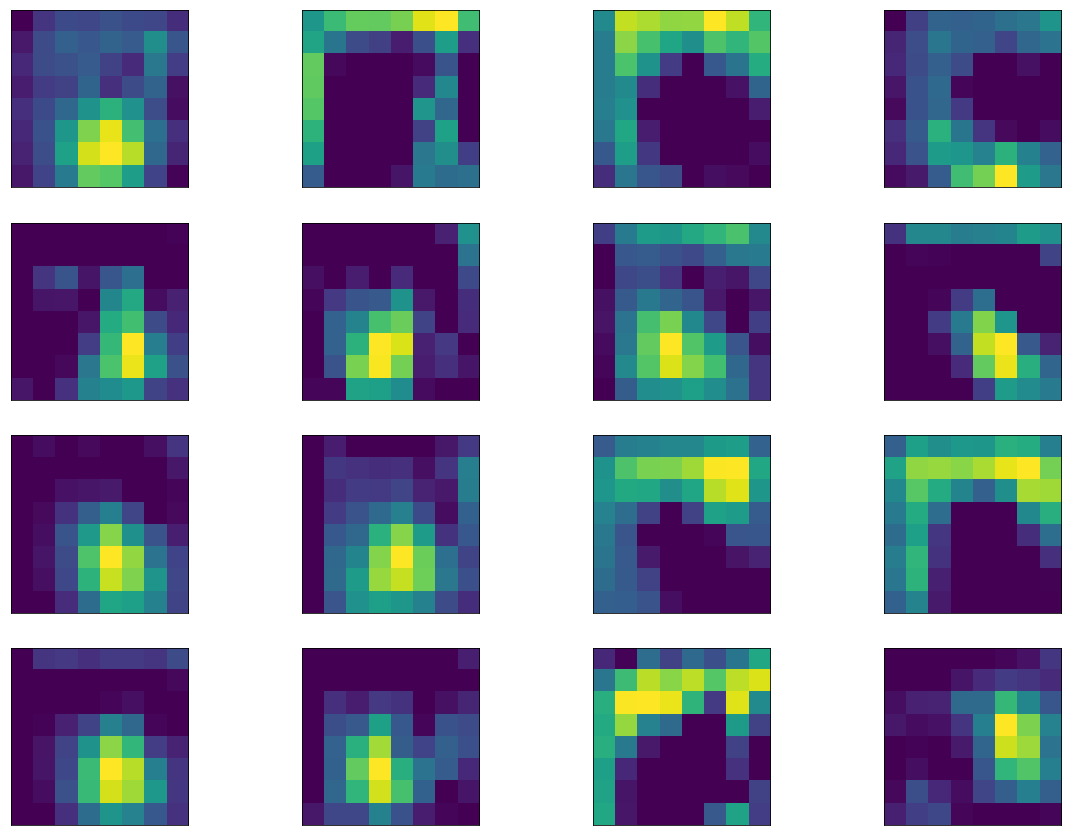

In [73]:
plot_layer(activations, image_number, 1)